# Installation

In [ ]:
try:
    import tangelo
    import pennylane as qml
except ModuleNotFoundError:
    !pip install git+https://github.com/goodchemistryco/Tangelo.git@develop  --quiet
    !pip install pyscf
    !pip install qulacs qiskit qiskit-aer  
    !pip install pennylane --upgrade

# Defining LiH

In [2]:
from tangelo import SecondQuantizedMolecule

LiH = [('Li', (0, 0, 0)),('H', (0, 0, 1.5949))] #these triples refer to coordinates
# the 1.5949 is experimentally determined to be the space betwn the elements
# see here for example https://cccbdb.nist.gov/expgeom2x.asp?casno=1333740

# use frozen_orbitals = None to set everything active for calculations
mol_LiH = SecondQuantizedMolecule(LiH, q=0, spin=0, basis="sto-3g")

# triples can be made using spin #, abs diff between alpha and beta electrons
# alpha = spin up, beta = spin-down, spin = alpha - beta electrons
mol_LiH_t = SecondQuantizedMolecule(LiH, q=0, spin=2, basis="sto-3g")

In [3]:
print(mol_LiH) # 2, 2 split between 0 and 1 oribtals
print(mol_LiH_t) # 2,1,1 splits between 0
print(mol_LiH.n_mos, mol_LiH.n_sos)

SecondQuantizedMolecule(xyz=[('Li', (0.0, 0.0, 0.0)), ('H', (0.0, 0.0, 1.5949))], q=0, spin=0, solver=<tangelo.toolboxes.molecular_computation.integral_solver_pyscf.IntegralSolverPySCF object at 0x7ee2e11d1090>, n_atoms=2, n_electrons=4, basis='sto-3g', ecp={}, symmetry=False, uhf=False, mf_energy=-7.8620269593941385, mo_energies=array([-2.34864417, -0.28570476,  0.07826185,  0.16393842,  0.16393842,
        0.54912925]), mo_occ=array([2., 2., 0., 0., 0., 0.]), n_mos=6, n_sos=12, active_occupied=[1], frozen_occupied=[0], active_virtual=[2, 3, 4, 5], frozen_virtual=[])
SecondQuantizedMolecule(xyz=[('Li', (0.0, 0.0, 0.0)), ('H', (0.0, 0.0, 1.5949))], q=0, spin=2, solver=<tangelo.toolboxes.molecular_computation.integral_solver_pyscf.IntegralSolverPySCF object at 0x7ee27d79cb10>, n_atoms=2, n_electrons=4, basis='sto-3g', ecp={}, symmetry=False, uhf=False, mf_energy=-7.766133365335707, mo_energies=NPArrayWithTag([-2.34705371, -0.26589778,  0.01337911,  0.16088823,
                 0.1608882

# Ground State Energy

In [4]:
from tangelo.algorithms import FCISolver, CCSDSolver
# classical energy calculations using FCI and CCSD
def getClassicalGround(mol):
    fci_solver = FCISolver(mol)
    fci_energy = fci_solver.simulate()
    
    
    
    ccsd_solver = CCSDSolver(mol)
    ccsd_energy = ccsd_solver.simulate()
    return fci_energy, ccsd_energy
    
fci_energy,ccsd_energy = getClassicalGround(mol_LiH)
print(f"LiH FCI Groud State Energy: {fci_energy}")
print(f"CCSD Groud State Energy: {ccsd_energy}")
print(f"Percent difference of FCI and CCSD: {100*(fci_energy-ccsd_energy)/fci_energy}%")

LiH FCI Groud State Energy: -7.8821759908012705
CCSD Groud State Energy: -7.882175990941344
Percent difference of FCI and CCSD: -1.7770946824323282e-09%


In [ ]:
from tangelo.algorithms import VQESolver

#100 cycles for speed's sake
vqe_options = {"molecule": mol_LiH, "verbose": True}

vqe_solver = VQESolver(vqe_options)
vqe_solver.build()
vqe_energy = vqe_solver.simulate()

#output not shown in notebook for clarity

In [11]:
print(f"VQE Ground State Energy: {vqe_energy}")
print(f"Percent difference of FCI and VQE: {100*(fci_energy-vqe_energy)/fci_energy}%")

VQE Ground State Energy: -7.88217484368532
Percent difference of FCI and VQE: 1.4553290259077517e-05%


# Construction of Trotter Suzuki Circuit to Simulate Hamiltonian

In [12]:
from tangelo.toolboxes.unitary_generator.trotter_suzuki import TrotterSuzukiUnitary

NUM_STEPS = 5

LiH_gnd_hamiltonian = vqe_solver.qubit_hamiltonian
ts_model = TrotterSuzukiUnitary(qubit_hamiltonian=LiH_gnd_hamiltonian)
ts_circuit = ts_model.build_circuit(NUM_STEPS)

In [ ]:
#we now need to do a simulation of our trotter suzuki circuit
print(ts_circuit)
ts_circuit.draw()

#output not shown in notebook for visual clarity

## QPE

In [35]:
# Obtain the fermionic Hamiltonian
fermionic_hamiltonian = mol_LiH.fermionic_hamiltonian

from tangelo.toolboxes.qubit_mappings.mapping_transform import fermion_to_qubit_mapping

# Choose a mapping scheme (e.g., Jordan-Wigner)
qubit_mapping = "JW"  # Options include "JW", "BK", etc.

# Map to qubit Hamiltonian
qu_op = fermion_to_qubit_mapping(
    fermionic_hamiltonian,
    mapping=qubit_mapping,
    n_spinorbitals=mol_LiH.n_active_sos,
    n_electrons=mol_LiH.n_active_electrons,
    spin=mol_LiH.spin,
    up_then_down=False
)
predicted_ground_state_energy = 7.88217484368532
# Shift ground state eigenvalue to be 0.25, such that a short-time QPE can return the exact energy
# (the exact ground state energy is known to be 7.88217599080127)
# see technique in 2a in https://github.com/sandbox-quantum/Tangelo-Examples/blob/main/hands_on/T5_fault_tolerant_build_blocks_solved.ipynb
qu_op += (0.25 + predicted_ground_state_energy)

In [36]:
from tangelo.toolboxes.qubit_mappings.statevector_mapping import get_reference_circuit

hf_circuit = get_reference_circuit(
    n_spinorbitals=mol_LiH.n_active_sos,
    n_electrons=mol_LiH.n_active_electrons,
    mapping=qubit_mapping,
    up_then_down=False,
    spin=mol_LiH.spin
)

In [37]:
import numpy as np
from openfermion import get_sparse_operator

eigs, eigenstates = np.linalg.eigh(get_sparse_operator(qu_op).toarray())
ground_sv = eigenstates[:, 0]
first_sv = eigenstates[:, 14]  

# Hartree-Fock reference state circuit
from tangelo.linq import Circuit, Gate, get_backend

sim = get_backend("cirq")

f, hf_sv = sim.simulate(hf_circuit, return_statevector=True)

# Dot product to compare how close the initial Hartree-Fock reference is to the ground and first excited singlet state.
g_ovlp = np.dot(hf_sv, ground_sv)
f_ovlp = np.dot(hf_sv, first_sv)
print(f"The overlap of the initial (Hartree-Fock) state with the exact ground state is        {g_ovlp}")
print(f"The overlap of the initial (Hartree-Fock) state with the exact first excited state is {f_ovlp}")

The overlap of the initial (Hartree-Fock) state with the exact ground state is        (0.9871537561234337+0j)
The overlap of the initial (Hartree-Fock) state with the exact first excited state is (2.7197618404656433e-17+0j)


In [38]:
from tangelo.toolboxes.ansatz_generator.ansatz_utils import trotterize, get_qft_circuit
from tangelo.linq import Circuit, Gate

# Define the list of ancilla qubits (e.g., the highest qubit indices)
n_ancilla = 3  # Adjust based on desired precision
qubit_list = list(range(mol_LiH.n_active_sos, mol_LiH.n_active_sos + n_ancilla))

# Initialize the QPE circuit
pe_circuit = Circuit()

# State preparation
pe_circuit += hf_circuit

# Apply Hadamard gates to ancilla qubits
pe_circuit += Circuit([Gate("H", q) for q in qubit_list])

# Controlled time evolution
for i, qubit in enumerate(qubit_list):
    # Calculate evolution time for each ancilla qubit
    t = -2 * np.pi * 2**i
    # Controlled-U operation
    pe_circuit += trotterize(
        qu_op,
        trotter_order=2,  # Adjust as needed
        n_trotter_steps=10,  # Adjust based on desired accuracy
        time=t,
        control=qubit
    )

# Apply inverse QFT
pe_circuit += get_qft_circuit(qubit_list, inverse=True)

In [39]:
# Simulate the circuit
freqs, _ = sim.simulate(pe_circuit)

from tangelo.toolboxes.post_processing.histogram import Histogram

hist = Histogram(freqs)
hist.remove_qubit_indices(*range(mol_LiH.n_active_sos))

In [40]:
for key, probability in hist.frequencies.items():    
    energy = sum(int(k)/2**(i+1) for i, k in enumerate(key))
    print(f"Measurement {key} with probability {probability:.5f} corresponds to energy {energy:.5f}")

Measurement 000 with probability 0.00458 corresponds to energy 0.00000
Measurement 001 with probability 0.00251 corresponds to energy 0.12500
Measurement 010 with probability 0.94245 corresponds to energy 0.25000
Measurement 011 with probability 0.00064 corresponds to energy 0.37500
Measurement 100 with probability 0.01520 corresponds to energy 0.50000
Measurement 101 with probability 0.00260 corresponds to energy 0.62500
Measurement 110 with probability 0.02811 corresponds to energy 0.75000
Measurement 111 with probability 0.00391 corresponds to energy 0.87500


Seeing the 0.25 with high probability confirms our predicted energy state

## QSE

In [41]:
# Obtaining molecular information here so we know how to make our list of operators
n_electrons = mol_LiH.n_active_electrons
n_spin_orbitals = mol_LiH.n_active_sos  
n_molecular_orbitals = n_spin_orbitals // 2 

# Number of occupied molecular orbitals (since each can hold 2 electrons)
n_occupied_mos = n_electrons // 2

print(f"Number of electrons: {n_electrons}")
print(f"Number of spin orbitals: {n_spin_orbitals}")
print(f"Number of molecular orbitals: {n_molecular_orbitals}")
print(f"Occupied molecular orbitals: {n_occupied_mos}")

Number of electrons: 2
Number of spin orbitals: 10
Number of molecular orbitals: 5
Occupied molecular orbitals: 1


In [42]:
import numpy as np
from scipy.linalg import eigh
from openfermion.utils import hermitian_conjugated as hc
from tangelo.toolboxes.operators import FermionOperator
from tangelo.toolboxes.qubit_mappings.mapping_transform import fermion_to_qubit_mapping as f2q_mapping

##this code follows the tangelo examples from here:
##https://github.com/sandbox-quantum/Tangelo-Examples/blob/main/examples/chemistry/excited_states.ipynb

##Check FermionOperator, why are values slightly off?

op_list = list()
for i in range(n_occupied_mos):
    for j in range(n_occupied_mos, n_molecular_orbitals):
        ##Spin-up to Spin-up
        op_list += [f2q_mapping(FermionOperator(((2*j, 1), (2*i, 0))), "jw")]
        ##Spin-down to Spin-down
        op_list += [f2q_mapping(FermionOperator(((2*j+1, 1), (2*i+1, 0))), "jw")]
        ##Spin-up to Spin-down
        op_list += [f2q_mapping(FermionOperator(((2*j+1, 1), (2*i, 0))), "jw")]
        ##Spin-down to Spin-up
        op_list += [f2q_mapping(FermionOperator(((2*j, 1), (2*i+1, 0))), "jw")]


size_mat = len(op_list)
h = np.zeros((size_mat, size_mat))
s = np.zeros((size_mat, size_mat))
state_circuit = vqe_solver.optimal_circuit
for i, op1 in enumerate(op_list):
    for j, op2 in enumerate(op_list):
        h[i, j] = np.real(vqe_solver.backend.get_expectation_value(hc(op1)*vqe_solver.qubit_hamiltonian*op2, state_circuit))
        s[i, j] = np.real(vqe_solver.backend.get_expectation_value(hc(op1)*op2, state_circuit))

eigenvalues, eigenvectors = eigh(h, s)
print("\nExcited States Energies:")
for idx, energy in enumerate(eigenvalues):
    print(f"State {idx}: Energy = {energy}")


Excited States Energies:
State 0: Energy = -7.735284005988082
State 1: Energy = -7.735279626574434
State 2: Energy = -7.735275250282784
State 3: Energy = -7.687181453080737
State 4: Energy = -7.680123617622705
State 5: Energy = -7.680123617553553
State 6: Energy = -7.680115696224129
State 7: Energy = -7.680115696154995
State 8: Energy = -7.680107770914089
State 9: Energy = -7.680107770844971
State 10: Energy = -7.630363229567549
State 11: Energy = -7.630363229456696
State 12: Energy = -7.465250028332574
State 13: Energy = -7.465238073971059
State 14: Energy = -7.465226121241107
State 15: Energy = -7.234251125205581


The energy states seen here are close in accuracy to those in the literature. We will now seek to make improvements to our methods

# Optimization and Noise and Ansatz Testing for Ground State

## Interpreting qubit states that was mapped using Jordan-Wigner mapping

In [21]:
from openfermion import get_sparse_operator
import numpy as np

# Get the qubit hamiltonian of LiH
LiH_gnd_hamiltonian = vqe_solver.qubit_hamiltonian

# Get the optimal circuit
optimal_circuit = vqe_solver.optimal_circuit

# Function for computing the tensor product
def kron_N(*ops):
    tmp = ops[0]
    for op in ops[1:]:
        tmp = np.kron(tmp,op)
    return tmp

# Apply the calculation of energy based on j-w mapping and the quantum states 
bra0 = np.array([[1,0]])
bra1 = np.array([[0,1]])
# print(np.array2string(kron_N(bra1,bra1,bra0,bra0,bra0,bra0,bra0,bra0,bra0,bra0)[0], threshold=np.inf))
LiH_jw_matrix = get_sparse_operator(LiH_gnd_hamiltonian)

# Function for computing the energy out of the quantum states
def evaluate_energy(quantum_states, print_state_energy=False):
    energy = []
    for prob_key, _ in quantum_states.items():
        braket = []
        for bit in prob_key:
            if bit == "1":
                braket.append(bra1)
            else:
                braket.append(bra0)
        HFbra = kron_N(*braket)
        HFket = HFbra.T
        energy.append(np.real(HFbra.dot(LiH_jw_matrix.dot(HFket)))[0][0])
    if print_state_energy:
        print(f'\nThe energy of each state:\n{dict(zip(quantum_states.keys(), energy))}')
    possibilities = np.array(list(quantum_states.values()))
    return np.sum(energy * possibilities)

## Run circuit simulations with/without noises on the backend

In [22]:
from tangelo.linq import get_backend, ONE_QUBIT_GATES, TWO_QUBIT_GATES
from tangelo.linq.noisy_simulation import NoiseModel

# Create a depolarization noise model to be used in future cells. All gates are treated with a noise level commonly seen in reality.
# In general, a one-qubit gate has lambda between 10^-4 to 10^-3, while a two-qubit gate has lambda between 10^-3 to 10^-2 (noisy hardware can go up to 10^-1).
nm = NoiseModel()
for g1 in ONE_QUBIT_GATES:
    nm.add_quantum_error(g1, 'depol', 0.001)
for g2 in TWO_QUBIT_GATES:
    nm.add_quantum_error(g2, 'depol', 0.01)

In [ ]:
# Get backends with noisy or noiseless 
noisy_backend = get_backend(target='qulacs', n_shots=10**3, noise_model=nm)
noiseless_backend = get_backend(target='qulacs')

noisy_probabilities = noisy_backend.simulate(optimal_circuit)[0]
noiseless_probabilities = noiseless_backend.simulate(optimal_circuit)[0]

# Simulate
print(noisy_probabilities,"\n")
print(noiseless_probabilities)

# output not shown for clarity

In [25]:
# Evaluate the performance of the noiseless backend
optimal_energy_backend_noiseless = evaluate_energy(noiseless_probabilities, print_state_energy=True)
print(f'\nThe energy calculated from the noiseless backend simulation that uses jordan-wigner mapping: {optimal_energy_backend_noiseless}')
print(f"LiH FCI Ground State Energy: {fci_energy}")
print(f"Relative error: {100*(fci_energy-optimal_energy_backend_noiseless)/fci_energy}%")


The energy of each state:
{'1100000000': -7.862026959394124, '0110000000': -7.708803341088391, '1001000000': -7.708803341088393, '0011000000': -7.1774908041332575, '0000110000': -7.196921401877651, '0000001100': -7.196921401877651, '0100000010': -7.357367580948617, '0001000010': -7.152812557941553, '1000000001': -7.357367580948614, '0010000001': -7.152812557941553, '0000000011': -6.81917331249928}

The energy calculated from the noiseless backend simulation that uses jordan-wigner mapping: -7.841312709870466
LiH FCI Ground State Energy: -7.8821759908012705
Relative error: 0.5184263961943169%


***Compared with the relative error of the quantum algorithm executed locally after the classical optimization, the performance drops DRAMATICALLY on backends.***

In [ ]:
# Evaluate the performance of the noisy backend
optimal_energy_backend_noisy = evaluate_energy(noisy_probabilities, print_state_energy=True)

In [28]:
print(f'\nThe energy calculated from the noisy backend simulation that uses j-w mapping: {optimal_energy_backend_noisy}')
print(f"LiH FCI Groud State Energy: {fci_energy}")
print(f"Relative error: {100*(fci_energy-optimal_energy_backend_noisy)/fci_energy}%")


The energy calculated from the noisy backend simulation that uses j-w mapping: -6.069121410485993
LiH FCI Groud State Energy: -7.8821759908012705
Relative error: 23.001955074730194%


***Given the relative error of this circuit on a noiseless simulator, this result on a noisy backend seems decent.***

## Trotterization on noisy and noiseless backends

Noiseless qulacs backend was used.

Probability of finding the ground state: 0.9743470071142875
Probability of finding the ground state after 1 second: 0.40119802720698916 



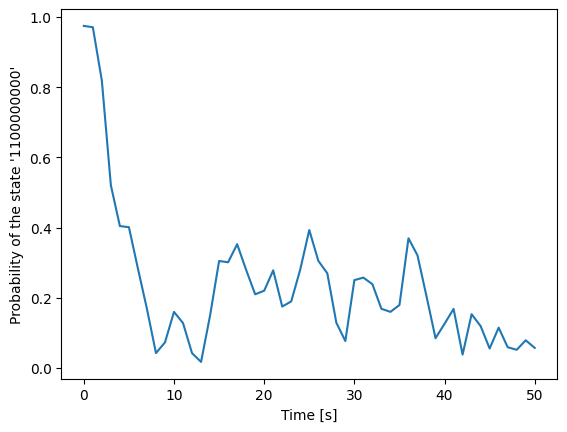

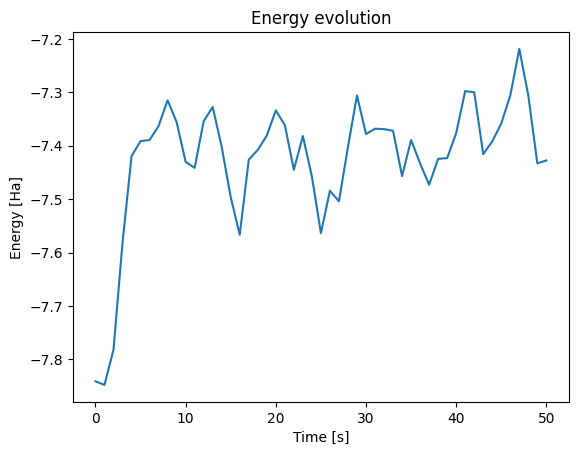

In [30]:
import matplotlib.pyplot as plt
# The most probable state depends on your qubit_mapping and up_then_down (ansatz choice affects up_then_down), 
# but it should nearly always be the molecule's initial state before any evolution.
most_probable_state = next(iter(noiseless_probabilities))

# When t is small (default time = 1.0 * NUM_STEPS = 1 = 1.0 second) in the time evolution, energy (quantum states) change is minimal as expected:
print("Noiseless qulacs backend was used.")
print(f'\nProbability of finding the ground state: {noiseless_probabilities[most_probable_state]}')
print(f'Probability of finding the ground state after 1 second: {noiseless_backend.simulate(optimal_circuit+ts_circuit)[0][most_probable_state]} \n')

# Can we see how it evolves? Let's try by plotting how the probability of the initial ground state changes:
def plot_state_prob_evolve(state, backend, time_step_for_ts = 1, time_until = 50):   
    t_array = np.arange(0, time_until + time_step_for_ts, time_step_for_ts)
    p_array = []
    ts_m = TrotterSuzukiUnitary(qubit_hamiltonian = LiH_gnd_hamiltonian, time = time_step_for_ts)
    for i in t_array / time_step_for_ts:
        ts = ts_m.build_circuit(i)
        p_array.append(backend.simulate(optimal_circuit + ts)[0][state])
    plt.figure()
    plt.plot(t_array,p_array)
    plt.xlabel("Time [s]")
    plt.ylabel(f"Probability of the state '{state}'")

# Can tune the function argumenets
plot_state_prob_evolve(most_probable_state, noiseless_backend)
    
# See how the energy evolves
energy_array = [evaluate_energy(noiseless_backend.simulate(optimal_circuit+TrotterSuzukiUnitary(qubit_hamiltonian=LiH_gnd_hamiltonian).build_circuit(i))[0]) 
                for i in range(51)]
plt.figure()
plt.title("Energy evolution")
plt.plot(range(51), energy_array)
plt.xlabel("Time [s]")
plt.ylabel("Energy [Ha]")
plt.show()

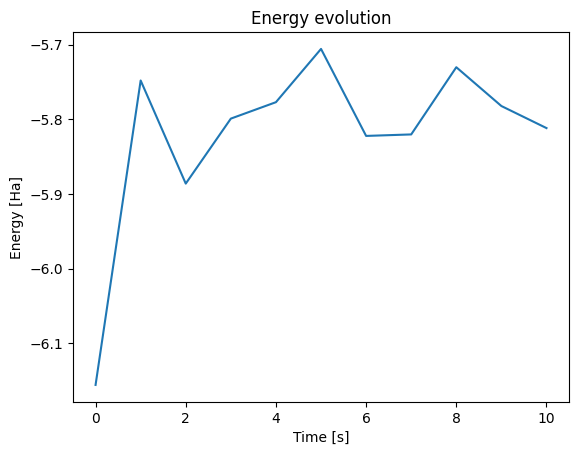

In [31]:
# Let's see how the dominant state at t = 0 evolves.
# plot_state_prob_evolve(most_probable_state, noisy_backend, time_step_for_ts = 0.05, time_until = 1.5)

# See how the energy evolves
energy_array = [evaluate_energy(noisy_backend.simulate(optimal_circuit+ts_model.build_circuit(i))[0]) for i in range(11)]

plt.figure()
plt.plot(range(11), energy_array)
plt.xlabel("Time [s]")
plt.ylabel("Energy [Ha]")
plt.title("Energy evolution")
plt.show()

***The energy drops more and a little faster, but the trend remains the same. Given that there are no longer dominant states as time passes, it's resonable to guess that because of decoherance, a quantum backend calculates the energy as being spread out among in various states, which isn't physically true--ground state should nearly always stays at ground state.***

## Mappings & Ansatze experiments with LiH and VQE

In [32]:
# Try different Mappings without changing the ansatze
from tangelo.algorithms import BuiltInAnsatze as Ansatze
# VQE-UCCSD on LiH with different qubit mappings
map_names = ['Jordan-Wigner', 'Bravyi-Kitaev', 'Symmetry Conserving Bravyi-Kitaev']
maps = ['jw', 'bk', 'scbk']
for name, qm in zip(map_names, maps):
    vqe1_options = {"molecule": mol_LiH, "ansatz": Ansatze.UCCSD, "up_then_down": True, "qubit_mapping": qm}
    vqe1_solver = VQESolver(vqe1_options)
    vqe1_solver.build()
    vqe1_solver.simulate()
    print(f"Qubit mapping currently in use: {name}\n")
    print(f"VQE Ground State Energy: {vqe1_solver.optimal_energy}")
    print(f"Percent difference of FCI and VQE: {100*(fci_energy-vqe1_solver.optimal_energy)/fci_energy}%")
    print(vqe1_solver.get_resources(), "\n")

Qubit mapping currently in use: Jordan-Wigner

VQE Ground State Energy: -7.882174298864892
Percent difference of FCI and VQE: 2.1465346378089946e-05%
{'qubit_hamiltonian_terms': 276, 'circuit_width': 10, 'circuit_depth': 1985, 'circuit_2qubit_gates': 1616, 'circuit_var_gates': 144, 'vqe_variational_parameters': 14} 

Qubit mapping currently in use: Bravyi-Kitaev

VQE Ground State Energy: -7.882172112668937
Percent difference of FCI and VQE: 4.920129083664343e-05%
{'qubit_hamiltonian_terms': 276, 'circuit_width': 10, 'circuit_depth': 1834, 'circuit_2qubit_gates': 1442, 'circuit_var_gates': 144, 'vqe_variational_parameters': 14} 

Qubit mapping currently in use: Symmetry Conserving Bravyi-Kitaev

VQE Ground State Energy: -7.882170877574115
Percent difference of FCI and VQE: 6.487075601241873e-05%
{'qubit_hamiltonian_terms': 276, 'circuit_width': 8, 'circuit_depth': 1660, 'circuit_2qubit_gates': 1276, 'circuit_var_gates': 144, 'vqe_variational_parameters': 14} 



In [33]:
# Try different Ansatz ('jw' as the mapping; HEA isn't compatible with 'jw')
from tangelo.algorithms import BuiltInAnsatze as Ansatze
name = ['UCCSD','ILC', 'QCC', 'QMF']
ansatz = [Ansatze.UCCSD, Ansatze.ILC, Ansatze.QCC, Ansatze.QMF]
print('Jordan-Wigner mapping was used for the following results.\n')

# "up_then_down" must be True for QCC-based Ansatze.
for n, az in zip(name, ansatz):
    vqe2_options = {"molecule": mol_LiH, "ansatz": az, "up_then_down": True, "qubit_mapping": 'jw'}
    vqe2_solver = VQESolver(vqe2_options)
    vqe2_solver.build()
    vqe2_solver.simulate()
    print(f"Ansatze currently in use: {n}\n")
    print(f"VQE Ground State Energy: {vqe2_solver.optimal_energy}")
    print(f"Percent difference of FCI and VQE: {100*(fci_energy-vqe2_solver.optimal_energy)/fci_energy}%")
    print(vqe2_solver.get_resources(), "\n")

Jordan-Wigner mapping was used for the following results.

Ansatze currently in use: UCCSD

VQE Ground State Energy: -7.8821742988638075
Percent difference of FCI and VQE: 2.1465360136547657e-05%
{'qubit_hamiltonian_terms': 276, 'circuit_width': 10, 'circuit_depth': 1985, 'circuit_2qubit_gates': 1616, 'circuit_var_gates': 144, 'vqe_variational_parameters': 14} 

Ansatze currently in use: ILC

VQE Ground State Energy: -7.881746411660309
Percent difference of FCI and VQE: 0.005450006970952614%
{'qubit_hamiltonian_terms': 276, 'circuit_width': 10, 'circuit_depth': 133, 'circuit_2qubit_gates': 98, 'circuit_var_gates': 31, 'vqe_variational_parameters': 26} 

Ansatze currently in use: QCC

VQE Ground State Energy: -7.881490166423205
Percent difference of FCI and VQE: 0.008700952362210244%
{'qubit_hamiltonian_terms': 276, 'circuit_width': 10, 'circuit_depth': 56, 'circuit_2qubit_gates': 36, 'circuit_var_gates': 26, 'vqe_variational_parameters': 26} 

Ansatze currently in use: QMF

VQE Ground 

In [34]:
# Try different Ansatz ('bk' as map)
name1 = ['UCCSD', 'HEA', 'ILC', 'QCC', 'QMF']
ansatz1 = [Ansatze.UCCSD, Ansatze.HEA, Ansatze.ILC, Ansatze.QCC, Ansatze.QMF]
print('Bravyi-Kitaev mapping was used for the following results.\n')

for n, az in zip(name1, ansatz1):
    vqe3_options = {"molecule": mol_LiH, "ansatz": az, "up_then_down": True, "qubit_mapping": 'bk'}
    vqe3_solver = VQESolver(vqe3_options)
    vqe3_solver.build()
    vqe3_solver.simulate()
    print(f"Ansatze currently in use: {n}\n")
    print(f"VQE Ground State Energy: {vqe3_solver.optimal_energy}")
    print(f"Percent difference of FCI and VQE: {100*(fci_energy-vqe3_solver.optimal_energy)/fci_energy}%")
    print(vqe3_solver.get_resources(), "\n")

# 'bk' mapping seems to be a little better for the default setting of UCCSD, but for ILC and QCC it depends on whether "up_then_down" is False.
# ILC and QCC provide the best balance between accuracy and circuit complexity compared to other ansatzes no matter the mapping used.

Bravyi-Kitaev mapping was used for the following results.

Ansatze currently in use: UCCSD

VQE Ground State Energy: -7.882172112668506
Percent difference of FCI and VQE: 4.9201296301714676e-05%
{'qubit_hamiltonian_terms': 276, 'circuit_width': 10, 'circuit_depth': 1834, 'circuit_2qubit_gates': 1442, 'circuit_var_gates': 144, 'vqe_variational_parameters': 14} 

Ansatze currently in use: HEA

VQE Ground State Energy: -7.715467924426582
Percent difference of FCI and VQE: 2.115000560368633%
{'qubit_hamiltonian_terms': 276, 'circuit_width': 10, 'circuit_depth': 14, 'circuit_2qubit_gates': 18, 'circuit_var_gates': 90, 'vqe_variational_parameters': 90} 

Ansatze currently in use: ILC

VQE Ground State Energy: -7.881746411660291
Percent difference of FCI and VQE: 0.005450006971177977%
{'qubit_hamiltonian_terms': 276, 'circuit_width': 10, 'circuit_depth': 127, 'circuit_2qubit_gates': 92, 'circuit_var_gates': 31, 'vqe_variational_parameters': 26} 

Ansatze currently in use: QCC

VQE Ground Stat

In [43]:
# Try different Ansatz ('scbk' as the mapping, which strictly requires "up_then_down" = True)
print('Symmetry Conserving Bravyi-Kitaev mapping was used for the following results.\n')

for n, az in zip(name1, ansatz1):
    vqe3_options = {"molecule": mol_LiH, "ansatz": az, "up_then_down": True, "qubit_mapping": 'scbk'}
    vqe3_solver = VQESolver(vqe3_options)
    vqe3_solver.build()
    vqe3_solver.simulate()
    print(f"Ansatze currently in use: {n}\n")
    print(f"VQE Ground State Energy: {vqe3_solver.optimal_energy}")
    print(f"Percent difference of FCI and VQE: {100*(fci_energy-vqe3_solver.optimal_energy)/fci_energy}%")
    print(vqe3_solver.get_resources(), "\n")

Symmetry Conserving Bravyi-Kitaev mapping was used for the following results.

Ansatze currently in use: UCCSD

VQE Ground State Energy: -7.882170877580905
Percent difference of FCI and VQE: 6.487066986712045e-05%
{'qubit_hamiltonian_terms': 276, 'circuit_width': 8, 'circuit_depth': 1660, 'circuit_2qubit_gates': 1276, 'circuit_var_gates': 144, 'vqe_variational_parameters': 14} 

Ansatze currently in use: HEA

VQE Ground State Energy: -7.862012861871749
Percent difference of FCI and VQE: 0.25580663198909026%
{'qubit_hamiltonian_terms': 276, 'circuit_width': 8, 'circuit_depth': 14, 'circuit_2qubit_gates': 14, 'circuit_var_gates': 72, 'vqe_variational_parameters': 72} 

Ansatze currently in use: ILC

VQE Ground State Energy: -7.881746411660284
Percent difference of FCI and VQE: 0.005450006971268123%
{'qubit_hamiltonian_terms': 276, 'circuit_width': 8, 'circuit_depth': 129, 'circuit_2qubit_gates': 94, 'circuit_var_gates': 27, 'vqe_variational_parameters': 22} 

Ansatze currently in use: QC

***We can conclude that the specific mapping should be tuned for each circuit, but the choice of Ansatze matters the most. For LiH and default optimizer in VQE, UCCSD is the most accurate (10^-7) one but produces the most complex circuit. ILC and QCC have a good balance (10^-5), though each might favor different mappings depending on the circuit. QMF produces the least complex circuit with a slightly higher relative relative error (10^-3).***

We now turn to the analysis of Metal Hydrides

# Density Matrix Embedding Theory (DMET) for Metal Hydrides

In [45]:
import json
from tangelo import SecondQuantizedMolecule
from tangelo.problem_decomposition import DMETProblemDecomposition
from tangelo.problem_decomposition.dmet import Localization
from tangelo.algorithms import VQESolver
from tangelo.algorithms import FCISolver

In [ ]:
## DMET-CCSD on CaH2, MgH2

In [46]:
#approximate CaH2 structure by taking the CaH bond lengths (2.003 Angstroms) and assume linear geometry
cah2 = """
Ca   0.0  0.0  0.0
H   0.0  0.0  -2.003
H   0.0  0.0  2.003
"""
mol_cah2 = SecondQuantizedMolecule(cah2, q=0, spin=0, basis="minao")

#approximate MgH2 structure by taking the MgH bond lengths (1.730 Angstroms) and assume linear geometry
mgh2 = """
Mg   0.0  0.0  0.0
H   0.0  0.0  -1.730
H   0.0  0.0  1.730
"""
mol_mgh2 = SecondQuantizedMolecule(mgh2, q=0, spin=0, basis="minao")

In [47]:
# Fragment definition = [1, 1, 1] to optimize computation resources, i.e. simulate each atom separately.

def DMET_energy(second_quantized_molecule):
    options_dmet = {"molecule": second_quantized_molecule,
                           "fragment_atoms": [1,1,1],
                           "fragment_solvers": "ccsd",
                           "verbose": True
                           }
    
    dmet = DMETProblemDecomposition(options_dmet)
    dmet.build()
    energy_dmet = dmet.simulate()
    print(f"DMET energy (hartree): \t {energy_dmet}")
    
    ###correlation energy calculation###
    energy_hf = dmet.mean_field.e_tot
    energy_corr = abs(energy_dmet - energy_hf)
    print(f"Correlation energy (hartree): \t {energy_corr}")
    # print(f"Correlation energy (kcal/mol): \t {627.5*energy_corr_butane}")

In [48]:
DMET_energy(mol_mgh2)

 	Iteration =  1
 	----------------
 
	SCF Occupancy Eigenvalues for Fragment Number : # 0
	[1.14672994 2.        ]

	SCF Occupancy Eigenvalues for Fragment Number : # 1
	[0.42663503 2.         2.         2.         2.         2.
 2.        ]

	SCF Occupancy Eigenvalues for Fragment Number : # 2
	[0.42663503 2.         2.         2.         2.         2.
 2.        ]

		Fragment Number : #  1
		------------------------
		Fragment Energy = -200.91948597656193
		Number of Electrons in Fragment = 10.858851090544944
		Fragment Number : #  2
		------------------------
		Fragment Energy = -3.489941406931463
		Number of Electrons in Fragment = 1.500460240855291
		Fragment Number : #  3
		------------------------
		Fragment Energy = -3.489941406931462
		Number of Electrons in Fragment = 1.5004602408552894
 	Iteration =  2
 	----------------
 
	SCF Occupancy Eigenvalues for Fragment Number : # 0
	[1.14672994 2.        ]

	SCF Occupancy Eigenvalues for Fragment Number : # 1
	[0.42663503 2.      

## Comparison with FCI, CCSD

In [49]:
from tangelo import SecondQuantizedMolecule
from tangelo.algorithms import FCISolver, CCSDSolver
from tangelo.algorithms import VQESolver

LiH = [('Li', (0, 0, 0)),('H', (0, 0, 1.5949))] #these triples refer to coordinates
mol_LiH = SecondQuantizedMolecule(LiH, q=0, spin=0, basis="sto-3g")
mol_LiH_t = SecondQuantizedMolecule(LiH, q=0, spin=2, basis="sto-3g")

NH3 = [('N', (0, 0, 0.1)), ('H', (0.94, 0, 0)), ('H', (-0.47, 0.81, 0)), ('H', (-0.47, -0.81, 0))]
mol_NH3 = SecondQuantizedMolecule(NH3, q=0, spin=0, basis="sto-3g")
mol_NH3_t = SecondQuantizedMolecule(NH3, q=0, spin=2, basis="sto-3g")

#Ca->(2.5369,0.155), H -> 2,-0.155), H -> (3.0739,-0.155)
CaH2 = [('Ca', (0, 0.155, 0)), ('H', (-0.5369, -0.155, 0)), ('H', (0.5369, -0.155, 0))]
mol_CaH2 = SecondQuantizedMolecule(CaH2, q=0, spin=0, basis="sto-3g")
mol_CaH2_t = SecondQuantizedMolecule(CaH2, q=0, spin=2, basis="sto-3g")

MgH2 = [('Mg', (0, 0, 0)), ('H', (0, 0, -1.730)), ('H', (0, 0, 1.730))]
mol_MgH2 = SecondQuantizedMolecule(MgH2, q=0, spin=0, basis="sto-3g")
mol_MgH2_t = SecondQuantizedMolecule(MgH2, q=0, spin=2, basis="sto-3g")

In [50]:
def FCI_CCSD(second_quantized_molecule):
    fci_solver = FCISolver(second_quantized_molecule)
    fci_energy = fci_solver.simulate()
    ccsd_solver = CCSDSolver(second_quantized_molecule)
    ccsd_energy = ccsd_solver.simulate()
    percent_difference = 100*(fci_energy-ccsd_energy)/fci_energy
    print("FCI energy, CCSD energy, percent_difference:")
    return fci_energy, ccsd_energy, percent_difference

In [51]:
FCI_CCSD(mol_MgH2)

FCI energy, CCSD energy, percent_difference:


(-198.2336730508314, -198.23333717857585, 0.00016943249367912803)

In [52]:
H10="""
H          1.6180339887          0.0000000000          0.0000000000
H          1.3090169944          0.9510565163          0.0000000000
H          0.5000000000          1.5388417686          0.0000000000
H         -0.5000000000          1.5388417686          0.0000000000
H         -1.3090169944          0.9510565163          0.0000000000
H         -1.6180339887          0.0000000000          0.0000000000
H         -1.3090169944         -0.9510565163          0.0000000000
H         -0.5000000000         -1.5388417686          0.0000000000
H          0.5000000000         -1.5388417686          0.0000000000
H          1.3090169944         -0.9510565163          0.0000000000
"""

mol_h10 = SecondQuantizedMolecule(H10, q=0, spin=0, basis="minao")

In the example below, we show resource requirements using standard parameters. Please note that other encodings could reduce the required resources, but resources would still be too much for current hardware.



In [53]:
options_h10_vqe = {"molecule": mol_h10, "qubit_mapping": "jw", "verbose": False}
vqe_h10 = VQESolver(options_h10_vqe)
vqe_h10.build()

Here are some resources estimation that would be needed for a direct VQE calculation on the initial problem, without DMET: for quantum computers in the NISQ era, tackling this head-on is a daunting task.

In [54]:
resources_h10_vqe = vqe_h10.get_resources()
print(resources_h10_vqe)

{'qubit_hamiltonian_terms': 4581, 'circuit_width': 20, 'circuit_depth': 40408, 'circuit_2qubit_gates': 35712, 'circuit_var_gates': 2220, 'vqe_variational_parameters': 350}


## 4.2 DMET-VQE

Here, we demonstrate how to perform DMET-VQE calculations using Tangelo package. The aim is to obtain improved results (vs HF energy) when compairing to the Full CI method (without using problem decomposition) and also using a quantum algorithm (VQE).

In [55]:
options_h10_dmet = {"molecule": mol_h10,
                    "fragment_atoms": [1]*10,
                    "fragment_solvers": "vqe",
                    "verbose": False
                    }

dmet_h10 = DMETProblemDecomposition(options_h10_dmet)
dmet_h10.build()

The dmet.build() method creates fragments (10) from the H10 molecule. When we decompose the ring of atoms into fragments including only one hydrogen atom each, the DMET method creates a fragment orbital (left: the single orbital distribution is shown in both pink and blue, with the colours depicting the phases) and the bath orbital (right: the single orbital distribution of the remaining nine hydrogen atoms is shown in both pink and blue, with the colours depicting the phases).

fragment_and_bath_orbitals

Resource estimation is done by calling dmet_h10.get_resources(). Here, a list of ten dictionaries is returned and stored in resources_h10_dmet. Each dictionary refers to a fragment. As every fragment is the same in this system (a single hydrogen atom), we only print one

In [56]:
resources_h10_dmet = dmet_h10.get_resources()
print(resources_h10_dmet[0])

{'qubit_hamiltonian_terms': 27, 'circuit_width': 4, 'circuit_depth': 100, 'circuit_2qubit_gates': 64, 'circuit_var_gates': 12, 'vqe_variational_parameters': 2}


Compared to a direct VQE algorithm, those resources are greatly reduced: from 20 qubits down to only 4 qubits in our case. Below, dmet_h10.simulate() computes the DMET-VQE energy.

The options currently selected specify that VQE must be run for each fragment, at each iteration of DMET: as such, it may take 2-3 minutes for this cell to finish. The verbose option is turned off to hide the lengthy prints: feel free to turn it back on to track the progress of this cell, if you'd like.

In [57]:
dmet_h10.verbose = False
energy_h10_dmet = dmet_h10.simulate()

print(f"DMET energy (hartree): \t {energy_h10_dmet}")

DMET energy (hartree): 	 -5.367523534265679


A comparison with an FCI calculation is then made.

In [58]:
fci_h10 = FCISolver(mol_h10)
energy_h10_fci = fci_h10.simulate()

print(f"FCI energy (hartree): \t {energy_h10_fci}")

FCI energy (hartree): 	 -5.3809260007310336


Lastly, we note that the DMET energy is closer to the FCI energy than the HF energy. DMET-VQE results are an improvement but are still not at the FCI level. This discrepancy is attributable to missing three, four ... many body interactions. When dismantling the system into fragments, we get a single hydrogen atom per fragment. Therefore, those fragments cannot propagate higher level (three and more) excitations. DMET user should have in mind this dilemma between fragment sizes and accuracy of the total electronic energy.

In [59]:
energy_h10_hf = dmet_h10.mean_field.e_tot
delta_h10_fci_hf = abs(energy_h10_fci - energy_h10_hf)
delta_h10_fci_dmet = abs(energy_h10_fci - energy_h10_dmet)

print(f"Difference FCI vs HF energies (hartree): \t\t {delta_h10_fci_hf}")
print(f"Difference FCI vs DMET-VQE energies (hartree): \t\t {delta_h10_fci_dmet}")
print(f"Difference FCI vs HF energies (kcal/mol): \t\t {627.5*delta_h10_fci_hf}")
print(f"Difference FCI vs DMET-VQE energies (kcal/mol): \t {627.5*delta_h10_fci_dmet}")

Difference FCI vs HF energies (hartree): 		 0.11680533556191719
Difference FCI vs DMET-VQE energies (hartree): 		 0.013402466465354479
Difference FCI vs HF energies (kcal/mol): 		 73.29534806510304
Difference FCI vs DMET-VQE energies (kcal/mol): 	 8.410047707009936


# Foundations of QDrift

In [18]:
import numpy
from pprint import pprint
import pennylane as qml
numpy.set_printoptions(threshold=10_000)

LiH_qml_hamiltonian = qml.qchem.import_operator(LiH_gnd_hamiltonian)

#some initial state can be used as input using hadamard as sub like in test
dev = qml.device("default.qubit", wires=10)
@qml.qnode(dev)
def buildQDrift(H):    
    qml.Hadamard(0)
    qml.QDrift(H, 1, n=5) # n == number of expoenentiaed terms
    return qml.probs()
pprint(buildQDrift(LiH_qml_hamiltonian))

tensor([0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. 